In [142]:
# conda create --name GAV_env python=3.9
# conda activate GAV_env

# conda install -c conda-forge keras=2.8.0
# conda install matplotlib=3.5.1
# conda install numpy=1.22.3
# conda install -c conda-forge tensorboard=2.8.0
# conda install -c conda-forge tensorboard-data-server=0.6.1
# conda install -c conda-forge tensorboard-plugin-wit=1.8.1
# conda install tensorflow=2.8.0
# conda install tensorflow-datasets=4.5.2
# conda install tensorflow-gpu=2.8.0


1. Import Dependencies and Data

In [143]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [144]:
# Configure GPU settings
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [145]:
# Load Fashion MNIST dataset
ds = tfds.load('fashion_mnist', split='train')

In [146]:
# Print the label of the first sample
print(ds.as_numpy_iterator().next()['label'])

2


In [147]:
# Print the first sample (features and label)
print(ds.as_numpy_iterator().next())

{'image': array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 6

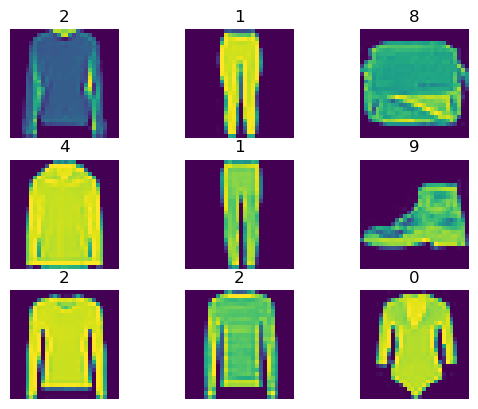

In [148]:
# To visualize the dataset
for i, example in enumerate(ds.take(9)):
    image, label = example["image"], example["label"]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(label.numpy())  # Convert label to numpy value
    plt.axis("off")

plt.show()

2. Visualize Data and Build Dataset

In [149]:
import numpy as np

In [150]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [151]:
# Getting data out of the pipeline
dataiterator.next()['image']
#every time new

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

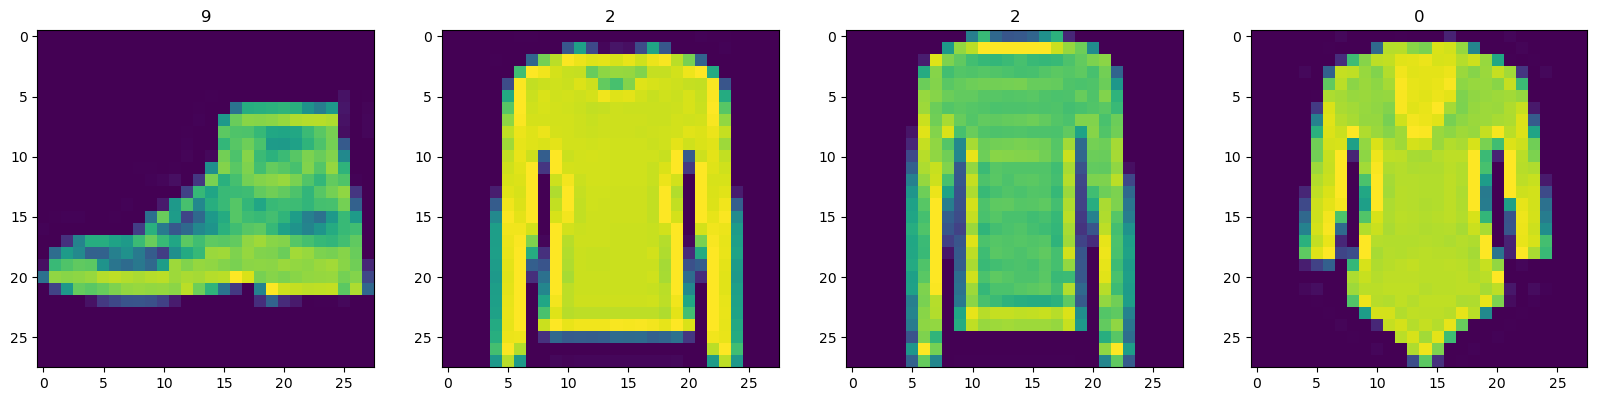

In [154]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [155]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [156]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [157]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

Build Generator

In [158]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D


In [159]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [160]:
generator = build_generator()

In [161]:
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_6 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_39 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [162]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

(4, 28, 28, 1)

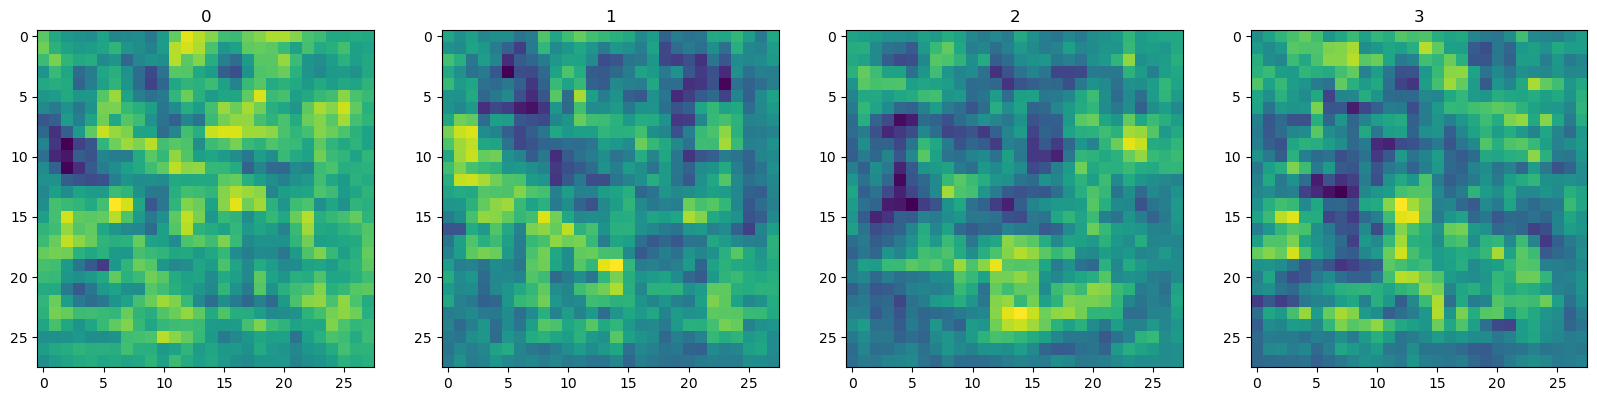

In [163]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

Build Discriminator

In [164]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [165]:
discriminator = build_discriminator()

In [166]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_30 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_31 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 128)     

In [167]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

(4, 28, 28, 1)

In [168]:
discriminator.predict(img)

array([[0.49930194],
       [0.49928194],
       [0.49931994],
       [0.4993252 ]], dtype=float32)

Construct Training Loop

In [169]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [170]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [171]:
#Build Subclassed Model

In [172]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [173]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [174]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [175]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

Build Callback

In [176]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [177]:
import os

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        # Create the directory if it does not exist
        if not os.path.exists('images'):
            os.makedirs('images')
        
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

Train

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=5, callbacks=[ModelMonitor()])

Review Performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

Test Out the Generator

Generate Images

In [203]:

imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

Save the Model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')